In [1]:
import pandas as pd
import folium
import math
import seaborn as sns
import requests

In [2]:
resto_df = pd.read_csv('https://raw.githubusercontent.com/QuentinF/IBM-Capstone-Project/master/resto_Paris.csv')

# Here I want to find the bestplace to add a new restaurant


In [ ]:
resto_df['local_authority'].value_counts().head(10)

In [206]:
resto_df = resto_df[resto_df['local_authority']=='Paris'].reset_index()

In [207]:
print(resto_df.columns)

#converting lat and long to float types else nan for deletion
def to_float(x):
    try:
        out = float(x)
    except:
        out = math.nan
    return out 
        
resto_df['latitude'] = resto_df['latitude'].apply(lambda x: to_float(x))
resto_df['longitude'] = resto_df['longitude'].apply(lambda x: to_float(x))

resto_df['latitude'].dropna(inplace=True)
resto_df['longitude'].dropna(inplace=True)

Index(['level_0', 'index', 'fas_id', 'name', 'address', 'postcode', 'easting',
       'northing', 'latitude', 'longitude', 'local_authority'],
      dtype='object')


In [208]:
resto_df['name'].describe()

count            494
unique           477
top       Revolution
freq               4
Name: name, dtype: object

So we have 22 duplicates

#### now let's see the areas where our pubs are located

I also want to include a radius of 500m as this is the size I will be limiting my venue search to, I will be using folium.Circle for this

In [3]:
# create map of using latitude and longitude values
resto_paris = folium.Map(location=[48.8588536, 2.3120407], zoom_start=12)


for lat, lng, name, local in zip(resto_paris['latitude'], resto_paris['longitude'], resto_paris['name'], resto_paris['local_authority']):
    label = '{}, {}'.format(name, local)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=250,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(pub_map)  
    
resto_paris

In [154]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


# 

nearby_venues = getNearbyVenues(names=restos_paris['name'],
                                   latitudes=restos_paris['latitude'],
                                   longitudes=restos_paris['longitude']
                                  )



In [189]:
#now let's find the pubs with the most restaurants nearby
nearby_restaurant_venues_count = nearby_restaurant_venues.groupby(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude'])['Venue Category'].count().sort_values(ascending=False).reset_index()

In [193]:
nearby_restaurant_venues_count.describe()

,Neighborhood Latitude,Neighborhood Longitude,Venue Category
count,285.000000,285.000000,285.000000
mean,53.406304,-2.960430,2.329825
std,0.019312,0.034597,1.251754
min,53.337317,-2.999843,1.000000
25%,53.400796,-2.982562,1.000000
50%,53.404676,-2.974052,2.000000
75%,53.408755,-2.946645,3.000000
max,53.472166,-2.834116,6.000000


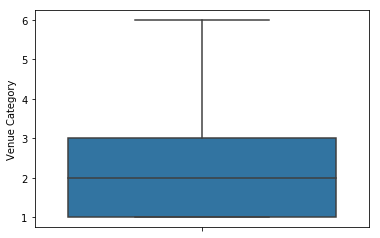

In [192]:
#now lets see how our restaurant data is distributed
sns.boxplot(data = nearby_restaurant_venues_count[['Neighborhood','Venue Category']], y='Venue Category')

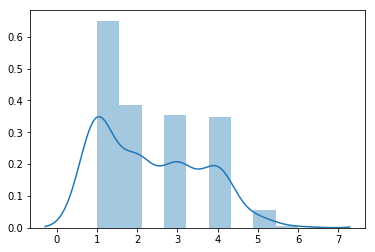

In [197]:
sns.distplot(nearby_restaurant_venues_count[['Venue Category']])